In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
conn = psycopg2.connect(database="keep_data", user="postgres", password="postgres", host="localhost", port="5432")
cur = conn.cursor()
df = psql.read_sql("Select * from markets_data", conn)
del df['time']
df.tail()

,open_b,close_b,high_b,low_b,vol_b,vol_conv_b,open,close,high,low,vol,vol_conv,average,cnt
100,0.002009,0.002106,0.002282,0.002002,80966.12,168.941963,0.784762,0.790339,0.853362,0.777077,1.106803e+06,8.861140e+05,0.800607,433
101,0.002104,0.002287,0.002541,0.002099,93551.66,210.427414,0.790217,0.910321,0.976179,0.788596,1.268048e+06,1.103147e+06,0.869957,597
102,0.002287,0.002200,0.002657,0.002200,62131.38,149.765756,0.909414,0.972085,1.012274,0.906893,1.039094e+06,1.004776e+06,0.966973,403
103,0.002200,0.002201,0.002426,0.002198,51683.99,119.167755,0.971193,0.977093,0.992536,0.934342,9.242518e+05,8.918199e+05,0.964910,313
104,0.002199,0.002182,0.002346,0.002021,87340.87,190.345875,0.978701,0.919141,0.990962,0.891322,1.879667e+06,1.810053e+06,0.962965,551


In [3]:
data_unsc = df.values
data = df.values
#data_norm = data
data_normaliser = preprocessing.MinMaxScaler()
data_norm = data_normaliser.fit_transform(data)

In [4]:
history_points = 30
pred_candel = 1

ohlcv_histories = np.array([data_norm[i:i + history_points].copy() for i in range(len(data_norm) - history_points-pred_candel)])
next_day_open_values = np.array([data_norm[:, 2][i + history_points+pred_candel].copy() for i in range(len(data_norm) - history_points-pred_candel)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

next_day_open_values_unsc = np.array([data_unsc[:, 2][i + history_points+pred_candel].copy() for i in range(len(data_unsc) - history_points-pred_candel)])
next_day_open_values_unsc = np.expand_dims(next_day_open_values_unsc, -1)

y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values_unsc)

test_split = 0.8
n = int(ohlcv_histories.shape[0] * test_split)
ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]
ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = next_day_open_values_unsc[n:]

ohlcv_train = np.reshape(ohlcv_train,(ohlcv_train.shape[0],ohlcv_train.shape[1]*ohlcv_train.shape[2],1))
ohlcv_test = np.reshape(ohlcv_test,(ohlcv_test.shape[0],ohlcv_test.shape[1]*ohlcv_test.shape[2],1))
ohlcv_train = np.reshape(ohlcv_train,(ohlcv_train.shape[0],ohlcv_train.shape[1]*ohlcv_train.shape[2]))
ohlcv_test = np.reshape(ohlcv_test,(ohlcv_test.shape[0],ohlcv_test.shape[1]*ohlcv_test.shape[2]))

In [5]:
ohlcv_train.shape


(59, 420)

In [7]:
from tensorflow import keras
model = keras.Sequential([

    keras.layers.Dense(1500,input_dim=ohlcv_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='linear')
])

opt = keras.optimizers.Adam(learning_rate=0.0005,decay=1e-6,)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mae'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1500)              631500    
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1500)              6000      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               750500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [8]:
history = model.fit(ohlcv_train, y_train, epochs=500,batch_size=100,validation_split=0.2)

Epoch 1/500
1/1 [==============================] - 0s 238ms/step - loss: 1.8032 - mae: 1.1373 - val_loss: 0.0046 - val_mae: 0.0515
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 2.7475 - mae: 1.2490 - val_loss: 0.0060 - val_mae: 0.0577
Epoch 3/500
1/1 [==============================] - 0s 26ms/step - loss: 2.2087 - mae: 1.0712 - val_loss: 0.0147 - val_mae: 0.1077
Epoch 4/500
1/1 [==============================] - 0s 27ms/step - loss: 1.3796 - mae: 0.9007 - val_loss: 0.0241 - val_mae: 0.1435
Epoch 5/500
1/1 [==============================] - 0s 26ms/step - loss: 1.8946 - mae: 1.0379 - val_loss: 0.0267 - val_mae: 0.1485
Epoch 6/500
1/1 [==============================] - 0s 27ms/step - loss: 1.5863 - mae: 1.0024 - val_loss: 0.0279 - val_mae: 0.1482
Epoch 7/500
1/1 [=====

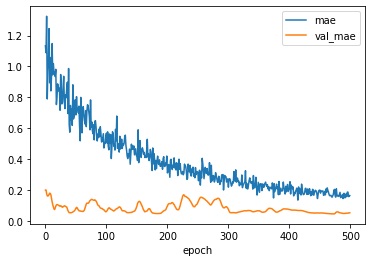

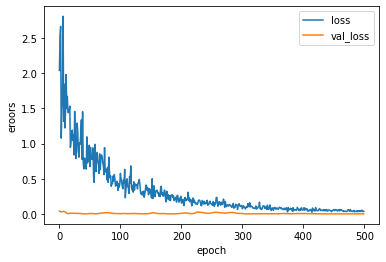

In [225]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('eroors')
plt.legend()
plt.show()

1/1 [==============================] - 0s 2ms/step - loss: 0.0130 - mae: 0.0895
Test metrics
MSE: 1.0640996307402151e-06
MAE: 0.0008796480978781184
MAPE: 29.89835846370521


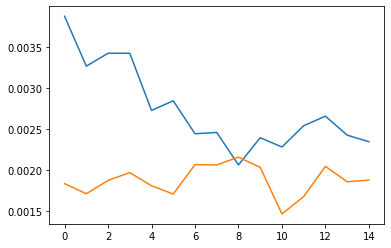

In [226]:
predictions = model.predict(ohlcv_test)
evaluate = model.evaluate(ohlcv_test,y_test)
predictions = y_normaliser.inverse_transform(predictions)
mse = np.mean(np.square(unscaled_y_test - predictions))
mae = np.sum(np.absolute((unscaled_y_test - predictions)))/len(unscaled_y_test)
mape = np.mean(np.abs((unscaled_y_test - predictions) / unscaled_y_test)) * 100
print("Test metrics")
print('MSE:',mse)
print('MAE:',mae)
print('MAPE:',mape)
s_plot = 0
e_plot = 20
plt.plot(unscaled_y_test[s_plot:e_plot])
plt.plot(predictions[s_plot:e_plot])

In [9]:
model.save("models\keep_predit_simple.h5")


